In [1]:
import torch
import numpy as np
import math
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

# 一. Scaled Dot-Product Attention機制

![jupyter](./scaled_dot_product_attention.png)

假設我們以$d$維的tensor來表示圖片。現有一張圖片$\mathbf{Q}$ (query)這張圖片中某一個部分為$\mathbf{K}$ (key)，例如一個瓶子或一張桌子。我們問：另一張以$d$維的tensor來表示的圖片$\mathbf{V}$ (value)之中，在與$\mathbf{Q}$相同的位置上有沒有$\mathbf{K}$的存在呢？

可以將將$\mathbf{Q}$和$\mathbf{K}$相乘後，$\mathbf{Q}$與$\mathbf{K}$相近的部分將會擁有比較大的值。新得出的tensor稱為attention map。此attention map再經過一個scale(以及一個mask會把某些部分的值換成一個很接近0的數字，如果有必要的話)，避免它的值爆掉。接著按照機器學習的老招數經過SoftMax值，我們就得到了一個直觀上功能類似filter的tensor，稱為attention weight。將此attention weight跟$\mathbf{V}$相乘，就可以找出$\mathbf{V}$在相同位置上是否有類似$\mathbf{K}$的存在。

attention weight可以通過一個dropout層避免overfitting。

注意：Scaling的時候並沒有規定一定要除以(或乘以)多少。它的目的只是避免值爆掉導致梯度算不出來。注意$\mathbf{K}$未必是$d$維的tensor，但我們可以透過replication和padding或其他方式讓它變成$d$維。

依上圖可以將此結構寫出來。注意到在這個函式中沒有任何參數需要訓練。

In [3]:
def scaled_dot_product_attention(query, key, value, dropout_p=0.0, scale=None) -> torch.Tensor:
    
    # 1. 計算attention map
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale # Scaling by sqrt of key dimension
    attn_weight = torch.matmul(query, key.transpose(-2, -1)) * scale_factor # Matrix multiplication
    attn_map = attn_weight
    
    # 2. 有些計算attention weight的過程會要加上某些bias，但這裡省略掉
#     L, S = query.size(-2), key.size(-2)
#     attn_bias = torch.zeros(L, S, dtype=query.dtype)
#     attn_weight += attn_bias
    
    # 3. 通過softmax層
    attn_weight = torch.softmax(attn_weight, dim=-1)
    
    # 4. 通過dropout層:避免over fitting
    attn_weight = nn.functional.dropout(attn_weight, p=dropout_p, training=True)
    
    # 5. 計算attention weight與value相乘並回傳
    return torch.matmul(attn_weight, value), attn_weight

## 1. 以實際的圖片為例，可視化Scaled Dot-Product Attentionk的物理意義

首先我們以一個三維的張量來表示一張圖片的RGB三個顏色。需要一個能夠顯示以pytorch的張量來顯示圖片的函式。

In [4]:
def show_image(image_tensor):
    # Convert the tensor to a numpy array and transpose it to [H, W, C]
    image_np = image_tensor.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis
    plt.show()

### (1) 產生query
打開圖片，這張圖片就會是我們的query $\mathbf{Q}$。

In [5]:
image_path = 'IMG_7241.JPG'
image = Image.open(image_path)
transform = transforms.ToTensor()
image_tensor = transform(image) # Convert the image to a PyTorch tensor and normalize it to [0, 1]

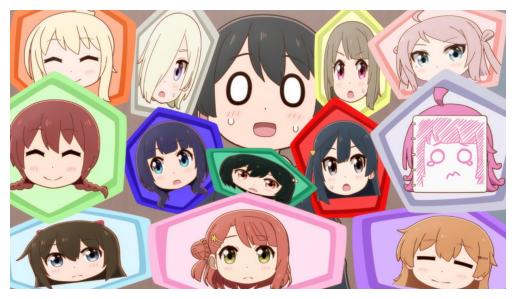

torch.Size([3, 675, 1200])

In [6]:
show_image(image_tensor)
image_tensor.size()

### (2) 產生key
這裡我想以侑的頭當成key，因此可以直接去調整load_and_crop_image()裡面left,top,right,bottom的數字去把頭取下來。因此我們需要一個可以切割圖片的函式。

In [7]:
def load_and_crop_image(image_path, crop_size):
    # Load the image
    image = Image.open(image_path)

    # Determine the size to crop the image to a square
    width, height = image.size
    min_dim = min(width, height)

    # Crop the image to the desired size
    left = ((width - min_dim) / 4)+300
    top = ((height - min_dim) / 4)
    right = ((width + min_dim) / 4)+300
    bottom = ((height + min_dim) / 4)
    image = image.crop((left, top, right, bottom))

    # Resize the image to the specified crop size
    image = image.resize((crop_size, crop_size))

    # Convert the image to a PyTorch tensor and normalize it to [0, 1]
    transform = transforms.ToTensor()
    image_tensor = transform(image)

    return image_tensor

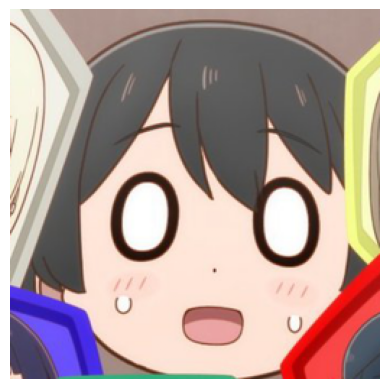

torch.Size([3, 256, 256])

In [8]:
# Example usage:
crop_size = 256  # Desired size for the cropped square image
crop_image_tensor = load_and_crop_image(image_path, crop_size)
show_image(crop_image_tensor)
crop_image_tensor.size()

接著將切下來的圖片利用複製貼上和Padding使其大小與原本的圖片相同，以此產生key $\mathbf{K}$。將此過程寫成一個函式來處理。

In [9]:
def pad_to_original_size(image_tensor, original_width, original_height):
    # Calculate the number of tiles needed
    num_tiles_width = (original_width // image_tensor.shape[2]) + 1
    num_tiles_height = (original_height // image_tensor.shape[1]) + 1

    # Create the tiled image by repeating the cropped image
    tiled_image = image_tensor.repeat(1, num_tiles_height, num_tiles_width)

    # Crop to the original size
    padded_image = tiled_image[:, :original_height, :original_width]
    
    # Calculate the padding dimensions
    pad_width = original_width - padded_image.shape[2]
    pad_height = original_height - padded_image.shape[1]

    # Pad the image
    padded_image = torch.nn.functional.pad(padded_image, 
                                           (0, pad_width, 0, pad_height), 
                                           mode='replicate')


    return padded_image

Padded image tensor shape: torch.Size([3, 675, 1200])


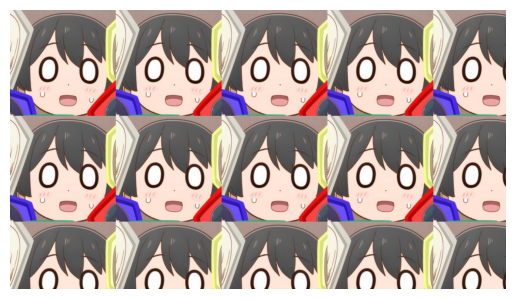

In [10]:
# Pad the cropped image to the original size
Q_width, Q_height = image.size
padded_image_tensor = pad_to_original_size(crop_image_tensor, Q_width, Q_height)

print(f"Padded image tensor shape: {padded_image_tensor.shape}")  # Should be [3, original_height, original_width]

# Show the padded image
show_image(padded_image_tensor)

### (3) 產生value
就是讀取一張新圖片而已。

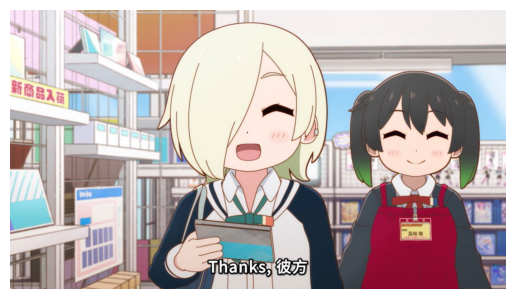

torch.Size([3, 675, 1200])

In [11]:
value_image = Image.open('value.JPG')
value_image_tensor = transform(value_image) # Convert the image to a PyTorch tensor and normalize it to [0, 1]
show_image(value_image_tensor)
value_image_tensor.size()

### (4) 計算attention map與attention weight並可視化

In [12]:
query = image_tensor
key = padded_image_tensor
value = value_image_tensor

In [13]:
heat_map, attention_weight = scaled_dot_product_attention(query, key, value, dropout_p=0.1)

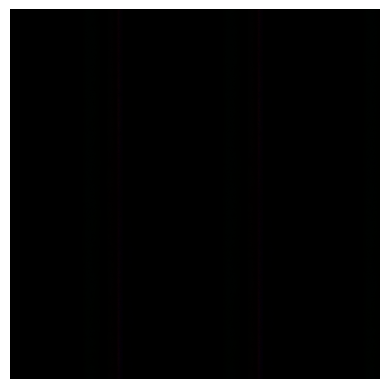

In [14]:
show_image(attention_weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


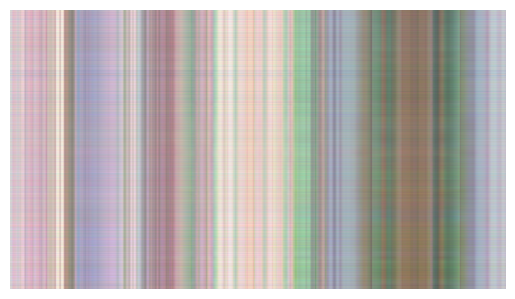

In [15]:
show_image(heat_map)

## 2. Self-attention

當$\mathbf{Q}=\mathbf{K}=\mathbf{V}$的時候，就稱為self-attention。我們用時間序列隨機生成一個張量，模擬自然語言經過encoding之後的特徵。以下是產生隨機序列的函式。

In [16]:
def generate_time_series(num_samples, sequence_length, num_variates):
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate 3 different time series
    time_series = []

    for _ in range(num_samples):
        # Generate random frequencies for each variate
        frequencies = torch.rand(num_variates) * 0.1 + 0.01

        # Generate time steps
        t = torch.linspace(0, 10, sequence_length)

        # Generate the time series for each variate
        series = torch.zeros(sequence_length, num_variates)
        for i in range(num_variates):
            amplitude = torch.rand(1).item() * 5 + 1
            phase = torch.rand(1).item() * 2 * np.pi
            trend = torch.linspace(0, torch.rand(1).item(), sequence_length)
            noise = torch.randn(sequence_length) * 0.1

            series[:, i] = amplitude * torch.sin(2 * np.pi * frequencies[i] * t + phase) + trend + noise

        time_series.append(series)

    return torch.stack(time_series)

### (1) 以自然語言的模擬為例
我們可以時間序列來模擬自然語言中一個句子中每個詞經編碼後而成的張量。

In [17]:
num_samples = 1 # 一句話
sequence_length = 5 # 這句話有五個token
num_variates = 3 # 每個token的embedding有三個分量

generated_data = generate_time_series(num_samples, sequence_length, num_variates)

print("Generated data shape:", generated_data.shape)
print(generated_data[:, :, :])

Generated data shape: torch.Size([1, 5, 3])
tensor([[[ 3.7979, -1.6929, -0.1767],
         [-4.1825, -1.6596,  0.5527],
         [-3.8719,  1.8562,  0.9264],
         [ 4.6407,  1.7788,  0.9307],
         [ 4.7957, -1.4390,  0.6234]]])


In [18]:
query = generated_data
key = generated_data
value = generated_data

In [19]:
heat_map, attention_weight = scaled_dot_product_attention(query, key, value, dropout_p=0.1)

In [20]:
print(heat_map)

tensor([[[ 5.1784, -1.5464,  0.5842],
         [-4.6411, -1.7736,  0.6216],
         [-4.3147,  1.9198,  1.0142],
         [ 5.1626,  1.8097,  1.0169],
         [ 5.2623, -1.4518,  0.6612]]])


In [21]:
print(attention_weight)

tensor([[[1.4616e-01, 0.0000e+00, 0.0000e+00, 2.7843e-02, 9.3711e-01],
         [3.8138e-09, 1.0911e+00, 1.9997e-02, 2.5489e-11, 3.4686e-10],
         [4.7352e-10, 4.0556e-02, 1.0706e+00, 5.3719e-09, 1.0248e-10],
         [1.7281e-03, 1.3698e-12, 1.4234e-10, 1.0594e+00, 4.9954e-02],
         [5.8573e-02, 1.8772e-11, 0.0000e+00, 5.0308e-02, 1.0022e+00]]])


Output的維度為$10\times512$，與$\mathbf{Q}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

### (2) 以圖片為例

In [22]:
heat_map, attention_weight = scaled_dot_product_attention(image_tensor, image_tensor, image_tensor, dropout_p=0.1)

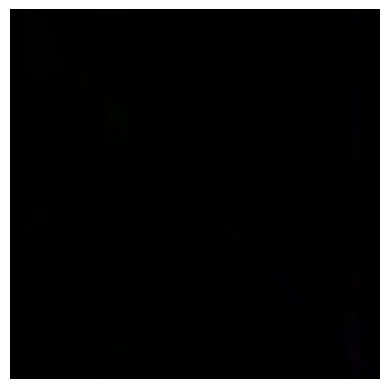

In [23]:
show_image(attention_weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


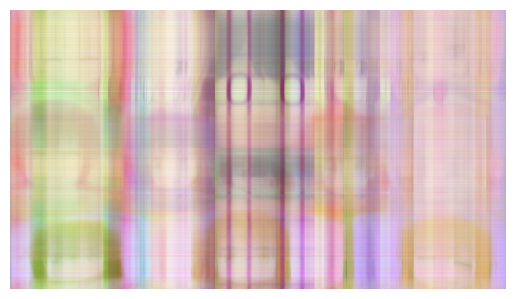

In [24]:
show_image(heat_map)

## 3. Multi-head Attention

![jupyter](./mha_img_original.png)
![jupyter](./multihead.png)

如果$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，得到$\mathbf{Q}_1,...,\mathbf{Q}_h$, $\mathbf{K}_1,...,\mathbf{K}_h$, $\mathbf{V}_1,...,\mathbf{V}_h$。那麼我們可以將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做attention。具體的方法是：
1. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別過一個linear layer
2. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，
3. 將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做Scaled Dot-Product attention
4. 將output出來的heat map接起來
5. 最後過一個linear layer得到output。
此過程就稱為稱為$h$-head之multi-head attention。

此方法亦可推廣到self-attention的情形。考慮自然語言的情形。當一句話有$N$個token，且每個token的embedding，比方說，都有512個分量。此時我們可以將這512個分量分組，比方說分成8組(稱為8 head)，每組64個分量。這樣一來，一句話的特徵本來是一個$N\times512$的張量$\mathbf{B}$，就被我們拆解成了8個$N\times64$的張量$\mathbf{B}_1,...,\mathbf{B}_8$。把這八個張量分別先過一個linear layer，再做self attention，得到8張heat map。我們可以說這代表8種自然語言中implicit的知識。最後，再將這8個heat map接起來並通過一個linear layer就算出Multi-head Attention了。

使用scaled_dot_product_attention()來做出multi-head attention。這裡用到view()這個函數，可以將tensor做resize。我們可以用這個方法來做multi-head切割。注意到linear layer是需要被訓練的。

In [25]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module 
        Credit: https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/SubLayers.py
    '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        ''' args:
            n_head: N head
            d_model: Output layer size and the initial embedding size of Q (as well as K and V here, in seld-attention context)
            d_k dimension of the key K
            d_v: dimension of the value V
        '''
        
        # args
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        
        # The paper asks to o linearly project the queries, keys and values h times with different, 
        # learned linear projections to dk, dk and dv dimensions, respectively.
        self.Q_linear = nn.Linear(d_model, n_head * d_k, bias=False)
        self.K_linear = nn.Linear(d_model, n_head * d_k, bias=False)
        self.V_linear = nn.Linear(d_model, n_head * d_v, bias=False)
        
        # Output layer
        self.out = nn.Linear(n_head * d_v, d_model, bias=False)

    def forward(self, q, k, v):
        ''' return values:
            q: heat map after multi-head attention. Size: [batch_size, num_of_token, d_model]
            attention_weight: Size: [batch_size, n_head, _, _]
        '''
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        batch_size, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        dropout_p = self.dropout
        
#         # Flatten all dimensions except batch and channels
#         q = q.flatten(2).transpose(1, 2)  # [batch_size, sequence_length, channels]
#         print(q)
#         k = k.flatten(2).transpose(1, 2)
#         v = v.flatten(2).transpose(1, 2)     

        # Linear projections
        q = self.Q_linear(q).view(batch_size, len_q, n_head, d_k)
        k = self.K_linear(k).view(batch_size, len_k, n_head, d_k)
        v = self.V_linear(v).view(batch_size, len_v, n_head, d_v)

        # Transpose to get dimensions (batch, head, seq_len, d_k)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        # Apply scaled dot-product attention
        q, attention_weight = scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

        # Transpose and reshape to concatenate all heads together
        q = q.transpose(1, 2).contiguous().view(batch_size, len_q, -1)

        # Final linear layer
        q = self.out(q)

        return q, attention_weight

### (1) 以自然語言的模擬為例

現假設$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別為三個句子經編碼後而成的張量，每個句子有10個token，每個token的embedding的長度為d_model。建立multi-head attention的物件並將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$三個句子送入其中，並使用8 head來做計算。

In [26]:
# Define the parameters
n_head = 8
d_model = 512
d_k = 64
d_v = 64
dropout = 0.1

# Initialize the MultiHeadAttention module
multi_head_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout)

In [27]:
# Create example tensors Q, K, and V with batch size
batch_size = 1 # Q, K, V分別有幾個句子
sequence_length = 10

Q = torch.rand(batch_size, sequence_length, d_model)
K = torch.rand(batch_size, sequence_length, d_model)
V = torch.rand(batch_size, sequence_length, d_model)

In [28]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = multi_head_attention(Q, K, V)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 10, 512])
Attention weights shape: torch.Size([1, 8, 10, 10])


Output的維度為$10\times512$，與$\mathbf{Q}, \mathbf{K}, \mathbf{V}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

### (2) 以圖片為例
$\mathbf{Q}, \mathbf{K}, \mathbf{V}\in\mathbb{R}^{3\times w \times h}$分別為三張圖片。每張圖片都有R,G,B三個channel，圖片的長寬分別為$h,w$。為了塞進去，我們可以將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [29]:
batch_size = 1 # Q, K, V分別有幾張圖片
c, w, h = image_tensor.size()

Q = image_tensor.view(batch_size, w*c, h)
K = padded_image_tensor.view(batch_size, w*c, h)
V = value_image_tensor.view(batch_size, w*c, h)

In [30]:
print(Q.size(), K.size(), V.size())

torch.Size([1, 2025, 1200]) torch.Size([1, 2025, 1200]) torch.Size([1, 2025, 1200])


In [31]:
# Define the parameters
n_head = 8
d_model = Q.size()[-1]  # Adjust d_model to match the input tensor's last dimension or projected dimension
d_k = d_model // n_head
d_v = d_model // n_head
dropout = 0.1

# Initialize the MultiHeadAttention module
multi_head_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout)

In [32]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = multi_head_attention(Q, K, V)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 2025, 1200])
Attention weights shape: torch.Size([1, 8, 2025, 2025])


算出來的結果要處理一下才有辦法看

In [33]:
output_img = output.view(c, w, h).detach()

In [34]:
# Find the minimum and maximum values in the tensor
min_val = torch.min(output_img)
max_val = torch.max(output_img)

# Apply min-max normalization
output_img = (output_img - min_val) / (max_val - min_val)

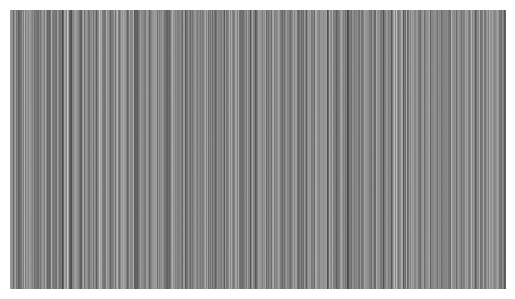

In [35]:
show_image(output_img)

# 二. Transformer的Encoder

## 1. Transformer的Encoder Block
這是Encoder block的樣子。就把東西串一串就接出來了。

![jupyter](./encoder_block.png)

每一個encoder block分為上下兩個sub-layer。
1. Lower sub-layer: 由Multi-head Attention與Add&Norm組成。Add&Norm是將Multi-head Attention的input與output相加後做layer normalization。
2. Upper sub-layer: 由數個fully connected layer與Add&Norm組成。Add&Norm會將Lower sublayer的input以及fully connected layer的output相加後做layer normalization。
此外原論文也提到，每個sublayer在做Add&Norm都有先接一個dropout。

將input和output加起來的手法稱為residual connection，其目的為

做layer normalization的目的是為了防止數值爆掉結果算不了梯度。此外，每個encoder block都可以當成一個度規空間。下一層block所代表的度規空間，其物理意義可能與上一層差很多，因此upper sub-layer用fully connected layer代表進行一個非線性的變換，用以連接兩個block。

In [36]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        ''' args:
            n_head: N head
            d_model: Output layer size and the initial embedding size of Q (as well as K and V here, in seld-attention context)
            d_inner: The size of fully connected layer in upper sub-layer. Since we only have one 
            d_k dimension of the key K
            d_v: dimension of the value V
        '''
        super(EncoderLayer, self).__init__()
        
        # Lower sub-layer
        self.self_attention = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.dropout_lower = nn.Dropout(dropout)
        self.layer_norm_lower = nn.LayerNorm(d_model, eps=1e-6)
        
        # Upper sub-layer
        self.FCN1 = nn.Linear(d_model, d_inner)
        self.FCN2 = nn.Linear(d_inner, d_model)
        self.dropout_upper = nn.Dropout(dropout)
        self.layer_norm_upper = nn.LayerNorm(d_model, eps=1e-6)     

    def forward(self, encoder_layer_input):
        ''' return values:
            x: the encoder layer output
            encoder_layer_attention_weights: multi-head attention map
        '''
        
        # Lower sub-layer
        residual = encoder_layer_input
        x, encoder_layer_attention_weights = self.self_attention(encoder_layer_input, encoder_layer_input, encoder_layer_input)
        x = self.dropout_lower(x)
        x = x + residual
        x = self.layer_norm_lower(x)
        
        # Upper sub-layer
        residual = x
        x = F.relu(self.FCN1(x))
        x = F.relu(self.FCN2(x))
        x = self.dropout_upper(x)
        x = x + residual
        x = self.layer_norm_upper(x)

        return x, encoder_layer_attention_weights

### (1) 以自然語言的模擬為例
模仿之前的例子，假設$\mathbf{Q}$為一個自然語言的句子經編碼後而成的張量，此句子有10個token，每個token的embedding的長度為d_model。設$d_\text{model}$為512。

In [37]:
# Define the parameters
n_head = 8
d_model = 512
d_inner = 128
d_k = 64
d_v = 64
dropout = 0.1

# Initialize the MultiHeadAttention module
encoder_layer = EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout)

In [38]:
# Create example tensors Q with batch size
batch_size = 1 # Q, K, V分別有幾個句子
sequence_length = 10

Q = torch.rand(batch_size, sequence_length, d_model)

In [39]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = encoder_layer(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 10, 512])
Attention weights shape: torch.Size([1, 8, 10, 10])


### (2) 以圖片為例
一樣模仿之前的例子。設$\mathbf{Q}\in\mathbb{R}^{3\times w \times h}$為一張有R,G,B三個channel的圖片，其長寬分別為$h,w$。將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [40]:
batch_size = 1 # 一個batch有幾張圖片
c, w, h = image_tensor.size()
Q = image_tensor.view(batch_size, w*c, h)

In [41]:
# Define the parameters
n_head = 8
d_model = Q.size()[-1]  # Adjust d_model to match the input tensor's last dimension or projected dimension
d_inner = 300
d_k = d_model // n_head
d_v = d_model // n_head
dropout = 0.1

# Initialize the MultiHeadAttention module
encoder_layer = EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout)

In [42]:
# Process the tensors through the MultiHeadAttention module
output, attention_weights = encoder_layer(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 2025, 1200])
Attention weights shape: torch.Size([1, 8, 2025, 2025])


In [43]:
output_img = output.view(c, w, h).detach()

# Find the minimum and maximum values in the tensor
min_val = torch.min(output_img)
max_val = torch.max(output_img)

# Apply min-max normalization
output_img = (output_img - min_val) / (max_val - min_val)

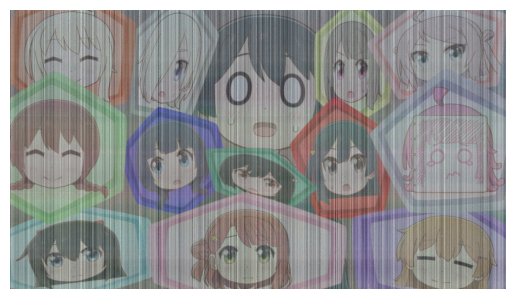

In [44]:
show_image(output_img)

## 2. Positional Encoding

Positional Encoding的物理意義是為模型提供與"位置"有關的訊息。因為Encoder block不像RNN有先後關係，也不像CNN反映空間頻率，因此需要另外添加關於每個單詞所在位置的編碼。論文中所用的編碼方式如下：
$$\Large{\text{PE}(\text{pos}, 2i) = \sin\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$
$$\Large{\text{PE}(\text{pos}, 2i+1) = \cos\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$

所產生的位置編碼$\mathbf{x}\in\mathbb{R}^{d_\text{model}}$，並將此embedding直接加到input data的embedding之中（雖然聽起來應該要接起來才好，但這招確實有用）。這麼做的物理意義是，因為單字經過編碼後，意義相近的單字更接近。而當位置更相近時，相同的單字更可能有相同的意義，因此才將兩種embedding直接相加。

In [45]:
def positional_encoding(length, depth):
    depth = depth // 2
    positions = torch.arange(length, dtype=torch.float).unsqueeze(1)  # (length, 1)
    depths = torch.arange(depth, dtype=torch.float).unsqueeze(0) / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    pos_encoding = torch.cat([torch.sin(angle_rads), torch.cos(angle_rads)], dim=-1)
    pos_encoding = pos_encoding.unsqueeze(0)  # Add batch dimension
    return pos_encoding

In [46]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length, d_model):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        #self.embedding = nn.Embedding(sequence_length, d_model)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def forward(self, x):
        length = x.size(1)
        #x = self.embedding(x) # Require all the data to be int64, so we turn of it here
        x *= math.sqrt(self.d_model)  # This factor sets the relative scale of the embedding and positional_encoding.
        x = x + self.pos_encoding[:, :length, :].to(x.device)
        return x

實際畫一下，感受position經過encoding出來是什麼東西。以下模擬一個長2048個token的句子，每一個token由$d_\text{model}=512$維的向量所編碼。

torch.Size([2048, 512])


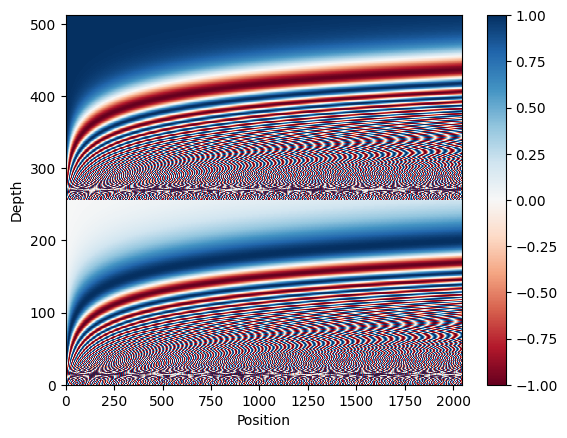

In [47]:
pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding[0].shape)
plt.pcolormesh(pos_encoding[0].numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

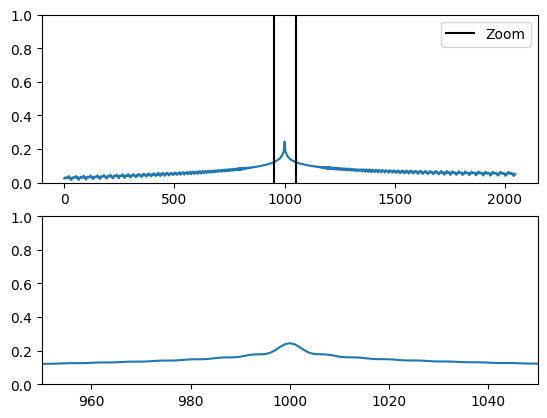

In [48]:
pos_encoding = pos_encoding / torch.norm(pos_encoding, dim=1, keepdim=True)
p = pos_encoding[0][1000]
dots = torch.einsum('pd,d->p', pos_encoding[0], p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

## 3. Encoder的建立
每一個Encoder都可以有很多個Layer，因此我們的Encoder在設計的時候也要能夠讓使用者自行決定層數。一般而言會把層數設在6，12，18...，不過資料不夠多的時候可以適當縮小之。

In [49]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_inner, sequence_length, dropout_rate=0.1):
        super(Encoder, self).__init__()
        ''' args:
            num_layers: How many layers should this model have
            d_model: The dimension of the output embedding
            num_heads: number of rates
            d_inner: The number of units in the FCNs of each layer
            sequence_length: The dimension of the embedding of each input instance
            dropout_rate: The dropout rate of each dropout layer in the model
        '''
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length, d_model=d_model)
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model=d_model, 
                                                      d_inner=d_inner, 
                                                      n_head=num_heads, 
                                                      d_k=d_model//num_heads, 
                                                      d_v=d_model//num_heads, 
                                                      dropout=dropout_rate)
                                         for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x, _ = self.enc_layers[i](x)

        return x

### (1) 以自然語言的模擬為例
模仿之前的例子，假設$\mathbf{Q}$為一個自然語言的句子經編碼後而成的張量，此句子有10個token，每個token的embedding的長度為d_model。設$d_\text{model}$為512。

In [50]:
sequence_length = 10
d_model = 512
num_heads = 8
d_inner = 128
num_layers = 4
dropout_rate = 0.1
encoder = Encoder(num_layers=num_layers, 
                  d_model=d_model, 
                  num_heads=num_heads, 
                  d_inner=d_inner, 
                  sequence_length=sequence_length,
                  dropout_rate=dropout_rate)

In [51]:
# Create example tensors Q with batch size
batch_size = 1 # Q有幾個句子
Q = torch.rand(batch_size, sequence_length, d_model)

In [52]:
# Process the tensors through the MultiHeadAttention module
output = encoder(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]

Output shape: torch.Size([1, 10, 512])


### (2) 以圖片為例
一樣模仿之前的例子。設$\mathbf{Q}\in\mathbb{R}^{3\times w \times h}$為一張有R,G,B三個channel的圖片，其長寬分別為$h,w$。將圖片resize成$\mathbb{R}^{3w \times h}$。亦即令$d_\text{model}=h$。

In [53]:
batch_size = 1 # 一個batch有幾張圖片
c, w, h = image_tensor.size()
Q = image_tensor.view(batch_size, w*c, h)

In [54]:
# Define the parameters
num_heads = 8
d_model = Q.size()[-1]  # Adjust d_model to match the input tensor's last dimension or projected dimension
sequence_length = Q.size()[-2]*Q.size()[-3]
d_inner = 300
dropout_rate = 0.1
num_layers = 6
encoder = Encoder(num_layers=num_layers, 
                  d_model=d_model, 
                  num_heads=num_heads, 
                  d_inner=d_inner, 
                  sequence_length=sequence_length,
                  dropout_rate=dropout_rate)

In [55]:
# Process the tensors through the MultiHeadAttention module
output = encoder(Q)

# Print the shapes of the output and attention weights
print(f"Output shape: {output.shape}")  # Should be [batch_size, sequence_length, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # Should be [batch_size, n_head, sequence_length, sequence_length]

Output shape: torch.Size([1, 2025, 1200])
Attention weights shape: torch.Size([1, 8, 2025, 2025])


In [56]:
output_img = output.view(c, w, h).detach()

# Find the minimum and maximum values in the tensor
min_val = torch.min(output_img)
max_val = torch.max(output_img)

# Apply min-max normalization
output_img = (output_img - min_val) / (max_val - min_val)

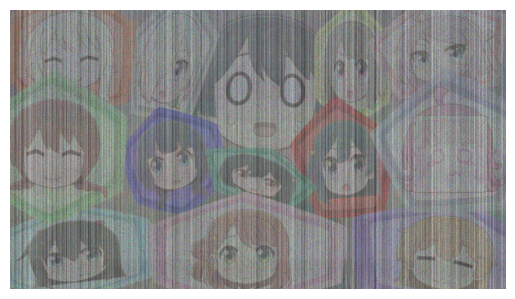

In [57]:
show_image(output_img)